In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import new_alg_v2 as na2
import matplotlib.pyplot as plt
import math

# New Section

In [ ]:
n_s = 30 # number of sample
n_ch = 3 # number of input channels 
d0 = 50 # dim0 of input image
d1 = 45 # dim1 of input image
n_epoch = 1
output_dim = n_s
kern_size=6
pool_size=3
target = torch.ones(output_dim,1)





# calc the parameters of the conv2d output:
H_out= math.floor(d0-kern_size+1)
W_out= math.floor(d1-kern_size+1)

# calc the dim after the pooling:
pool_H_out= math.floor(((H_out-pool_size)/pool_size)+1)
pool_W_out= math.floor(((W_out-pool_size)/pool_size)+1)

# clac the dim of nn.Linear
final_dim=pool_H_out*pool_W_out

print('Hout is: ',H_out)
print('Wout is: ',W_out)
print('pool_H_out is: ', pool_H_out)
print('pool_W_out is: ', pool_W_out)





Hout is:  45
Wout is:  40
pool_H_out is:  15
pool_W_out is:  13


In [ ]:
# dataset
DS = torch.normal(0, 1, size=(n_s, n_ch, d0, d1))


In [ ]:
class toy_CNN(nn.Module):
    def __init__(self, n_ch):
        super(toy_CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, 1, bias=False)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x),pool_size)
        x = x.view(-1, final_dim)
        x = self.fc1(x)
        return x

In [ ]:
def train(net, eta, n_epoch, dataset, target):
    train_losses = []
    net.train()
    loss = torch.nn.MSELoss()
    optimizer = na2.new_alg(net.parameters(), lr=eta)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        py_hat = net(dataset)
        objective = loss(py_hat, target)
        train_losses.append(float(objective))
        objective.backward()
        optimizer.step()
    return train_losses

In [ ]:
def test(net, dataset, target):
    net.eval()
    loss = torch.nn.MSELoss()
    with torch.no_grad():
        output = net(dataset)
        test_loss = loss(output, target)
    return float(test_loss)

In [ ]:
def xl_calc(eta, n_ch):
    network = toy_CNN(n_ch)
    conv1_init = network.conv1.weight.clone()
    fc1_init = network.fc1.weight.clone()
    
    initial_loss = test(network, DS, target)
    test_loss = train(network, eta, n_epoch, DS, target)
    final_loss = test(network, DS, target)
    
    conv1_final = network.conv1.weight.clone()
    fc1_final = network.fc1.weight.clone()
    
    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    
    loss_conv1 = test(network, DS, target)
    
    #init weights fc1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.fc1.weight[:] = fc1_init
    
    loss_fc1 = test(network, DS, target)
    
    dL = final_loss - initial_loss
   # print("for lr =",  eta, ":")
  #  print("  inital loss = ", initial_loss)
   # print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
    #  print("   ***dL zero***")
      return
    
    Xl1 = (final_loss - loss_conv1)/dL
    Xl2 = (final_loss-loss_fc1)/dL
 #   if True:
      #print("for lr =",  eta, ":")
   #   print("  Xl1 = ", float(Xl1))
    #  print("  Xl2 = ", float(Xl2))
    return Xl1, Xl2
    

In [ ]:
lrs = np.logspace(-5,-7,10)
for lr in lrs:
  xl_calc(lr, n_ch)

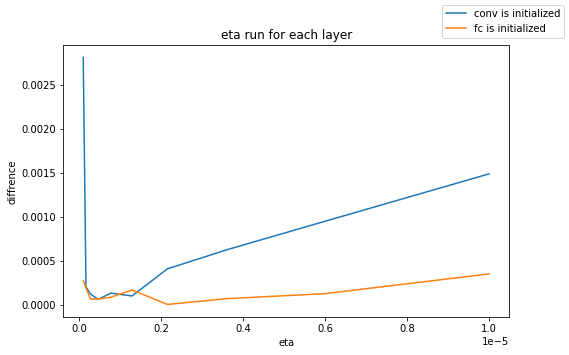

In [ ]:
from torch.nn.modules import conv
# create the vector of the diffrence between the layers:
conv_v = []
fc_v=[]
lrs = np.logspace(-5,-7,10)
for lr in lrs:
    conv_diff= 0
    fc_diff=0
    for i in range(100):
      Xl1, Xl2 =xl_calc(lr, n_ch)
      conv_diff=conv_diff+0.01*float(Xl1)
      fc_diff=fc_diff+0.01*float(Xl2)

    conv_v.append(abs(0.5-conv_diff))
    fc_v.append(abs(0.5-fc_diff))

#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs,conv_v,label="conv is initialized")
plt.plot(lrs,fc_v, label="fc is initialized")

plt.ylabel('diffrence')
plt.xlabel('eta')
plt.title("eta run for each layer")
fig.legend()


**Double conv layer, one FC**

The net params:

In [ ]:
n_s = 30 # number of sample
n_ch = 3 # number of input channels 
d0 = 50 # dim0 of input image
d1 = 45 # dim1 of input image
n_epoch = 1
output_dim = n_s
kern_size=6
pool_size=3
target = torch.ones(output_dim,1)





# calc the parameters of the conv1 out put:
H_out_conv1= math.floor(d0-kern_size+1)
W_out_conv1= math.floor(d1-kern_size+1)

# calc the dim after the pooling:
pool_H_out= math.floor(((H_out_conv1-pool_size)/pool_size)+1)
pool_W_out= math.floor(((W_out_conv1-pool_size)/pool_size)+1)

# calc the parameters of the conv2 out put:
H_out_conv2= math.floor(pool_H_out-kern_size+1)
W_out_conv2= math.floor(pool_W_out-kern_size+1)

# calc the dim after the pooling:
pool2_H_out= math.floor(((H_out_conv2-pool_size)/pool_size)+1)
pool2_W_out= math.floor(((W_out_conv2-pool_size)/pool_size)+1)

# clac the dim of nn.Linear
final_dim=pool2_H_out*pool2_W_out

print('Hout1 is: ',H_out_conv1)
print('Wout1 is: ',W_out_conv1)
print('Hout2 is: ',H_out_conv2)
print('Wout2 is: ',W_out_conv2)
print('pool_H_out is: ', pool_H_out)
print('pool_W_out is: ', pool_W_out)
print('pool2_H_out is: ', pool2_H_out)
print('pool2_W_out is: ', pool2_W_out)
print('fin dim is: ', final_dim)
# dataset
DS = torch.normal(0, 1, size=(n_s, n_ch, d0, d1))





Hout1 is:  45
Wout1 is:  40
Hout2 is:  10
Wout2 is:  8
pool_H_out is:  15
pool_W_out is:  13
pool2_H_out is:  3
pool2_W_out is:  2
fin dim is:  6


In [ ]:
class toy_CNN_double_conv(nn.Module):
    def __init__(self, n_ch):
        super(toy_CNN_double_conv, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, 1, bias=False)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x),pool_size)
        x = F.max_pool2d(self.conv2(x),pool_size)
        x = x.view(-1, final_dim)
        x = self.fc1(x)
        return x

In [ ]:
def x_3l_calc(eta, n_ch):

    #define the net and save init params
    network = toy_CNN_double_conv(n_ch)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()

    #train and save init and final loss
    initial_loss = test(network, DS, target)
    test_loss = train(network, eta, n_epoch, DS, target)
    final_loss = test(network, DS, target)

    #  save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    
    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, DS, target)

        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, DS, target)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    
    loss_fc1 = test(network, DS, target)
    
    dL = final_loss - initial_loss
   # print("for lr =",  eta, ":")
  #  print("  inital loss = ", initial_loss)
   # print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
    #  print("   ***dL zero***")
      return
    
    Xl_conv1 = (final_loss - loss_conv1)/dL
    Xl_conv2 = (final_loss - loss_conv2)/dL
    Xl_fc1 = (final_loss-loss_fc1)/dL
 #   if True:
      #print("for lr =",  eta, ":")
   #   print("  Xl1 = ", float(Xl1))
    #  print("  Xl2 = ", float(Xl2))
    return Xl_conv1, Xl_conv2,Xl_fc1
    

In [ ]:
lrs = np.logspace(-2,-5,10)
diff_v_conv1=[]
diff_v_conv2=[]
diff_v_fc1=[]

for lr in lrs:
    diff_conv1= 0
    diff_conv2= 0
    diff_fc1= 0
    for i in range(100):
      conv1,conv2,fc1=x_3l_calc(lr, n_ch)
      diff_conv1=diff_conv1+0.01*conv1
      diff_conv2=diff_conv2+0.01*conv2
      diff_fc1=diff_fc1+0.01*fc1

    diff_conv1=abs((1/3)-diff_conv1)
    diff_conv2=abs((1/3)-diff_conv2)
    diff_fc1=abs((1/3)-diff_fc1)

    diff_v_conv1.append(diff_conv1)
    diff_v_conv2.append(diff_conv2)
    diff_v_fc1.append(diff_fc1)
  

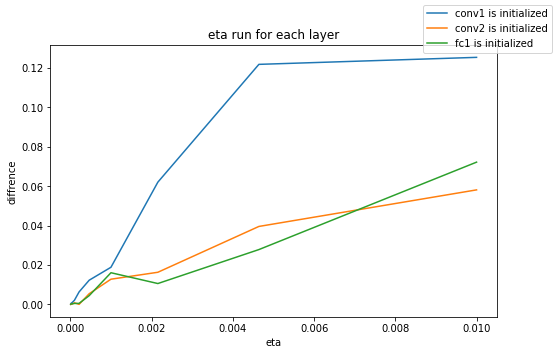

In [ ]:
#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs,diff_v_conv1,label="conv1 is initialized")
plt.plot(lrs,diff_v_conv2, label="conv2 is initialized")
plt.plot(lrs,diff_v_fc1, label= "fc1 is initialized")

plt.ylabel('diffrence')
plt.xlabel('eta')
plt.title("eta run for each layer")
fig.legend()


**doble conv, dounle FC**

In [ ]:
n_s = 30 # number of sample
n_ch = 3 # number of input channels 
d0 = 50 # dim0 of input image
d1 = 45 # dim1 of input image
fc2_in= 10
n_epoch = 1
output_dim = n_s
kern_size=6
pool_size=3
target = torch.ones(output_dim,1)





# calc the parameters of the conv1 out put:
H_out_conv1= math.floor(d0-kern_size+1)
W_out_conv1= math.floor(d1-kern_size+1)

# calc the dim after the pooling:
pool_H_out= math.floor(((H_out_conv1-pool_size)/pool_size)+1)
pool_W_out= math.floor(((W_out_conv1-pool_size)/pool_size)+1)

# calc the parameters of the conv2 out put:
H_out_conv2= math.floor(pool_H_out-kern_size+1)
W_out_conv2= math.floor(pool_W_out-kern_size+1)

# calc the dim after the pooling:
pool2_H_out= math.floor(((H_out_conv2-pool_size)/pool_size)+1)
pool2_W_out= math.floor(((W_out_conv2-pool_size)/pool_size)+1)

# clac the dim of nn.Linear
final_dim=pool2_H_out*pool2_W_out

print('Hout1 is: ',H_out_conv1)
print('Wout1 is: ',W_out_conv1)
print('Hout2 is: ',H_out_conv2)
print('Wout2 is: ',W_out_conv2)
print('pool_H_out is: ', pool_H_out)
print('pool_W_out is: ', pool_W_out)
print('pool2_H_out is: ', pool2_H_out)
print('pool2_W_out is: ', pool2_W_out)
print('fin dim is: ', final_dim)
# dataset
DS = torch.normal(0, 1, size=(n_s, n_ch, d0, d1))





Hout1 is:  45
Wout1 is:  40
Hout2 is:  10
Wout2 is:  8
pool_H_out is:  15
pool_W_out is:  13
pool2_H_out is:  3
pool2_W_out is:  2
fin dim is:  6


In [ ]:
class full_CNN(nn.Module):
    def __init__(self, n_ch):
        super(full_CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, fc2_in, bias=False)
        self.fc2= nn.Linear( fc2_in,1, bias=False)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x),pool_size)
        x = F.max_pool2d(self.conv2(x),pool_size)
        x = x.view(-1, final_dim)
        x = self.fc1(x)
        x= self.fc2(x)
        return x

In [ ]:
def x_full_calc(eta, n_ch):

    #define the net and save init params
    network = full_CNN(n_ch)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()
    fc2_init = network.fc2.weight.clone()


    #train and save init and final loss
    initial_loss = test(network, DS, target)
    test_loss = train(network, eta, n_epoch, DS, target)
    final_loss = test(network, DS, target)

    #  save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    fc2_final = network.fc2.weight.clone()

    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, DS, target)

        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, DS, target)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    loss_fc1 = test(network, DS, target)

    #init weights fc2
    with torch.no_grad():
      network.fc1.weight[:] = fc1_final
      network.fc2.weight[:] = fc2_init

    loss_fc2 = test(network, DS, target)
    
    dL = final_loss - initial_loss
   # print("for lr =",  eta, ":")
  #  print("  inital loss = ", initial_loss)
   # print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
    #  print("   ***dL zero***")
      return
    
    Xl_conv1 = (final_loss - loss_conv1)/dL
    Xl_conv2 = (final_loss - loss_conv2)/dL
    Xl_fc1 = (final_loss-loss_fc1)/dL
    Xl_fc2 = (final_loss-loss_fc2)/dL

 #   if True:
      #print("for lr =",  eta, ":")
   #   print("  Xl1 = ", float(Xl1))
    #  print("  Xl2 = ", float(Xl2))
    return Xl_conv1, Xl_conv2,Xl_fc1,Xl_fc2
    

In [ ]:
lrs = np.logspace(-2,-5,10)
diff_v_conv1=[]
diff_v_conv2=[]
diff_v_fc1=[]
diff_v_fc2=[]


for lr in lrs:
    diff_conv1= 0
    diff_conv2= 0
    diff_fc1= 0
    diff_fc2= 0
    for i in range(100):
      conv1,conv2,fc1,fc2=x_full_calc(lr, n_ch)
      diff_conv1=diff_conv1+0.01*conv1
      diff_conv2=diff_conv2+0.01*conv2
      diff_fc1=diff_fc1+0.01*fc1
      diff_fc2=diff_fc2+0.01*fc2

    diff_conv1=abs((1/4)-diff_conv1)
    diff_conv2=abs((1/4)-diff_conv2)
    diff_fc1=abs((1/4)-diff_fc1)
    diff_fc2=abs((1/4)-diff_fc2)

    diff_v_conv1.append(diff_conv1)
    diff_v_conv2.append(diff_conv2)
    diff_v_fc1.append(diff_fc1)
    diff_v_fc2.append(diff_fc2)

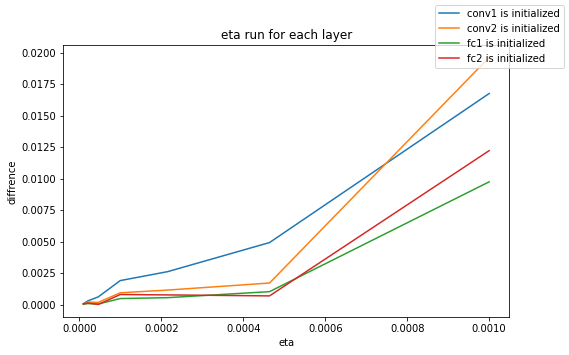

In [ ]:
#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs[3:10],diff_v_conv1[3:10],label="conv1 is initialized")
plt.plot(lrs[3:10],diff_v_conv2[3:10], label="conv2 is initialized")
plt.plot(lrs[3:10],diff_v_fc1[3:10], label= "fc1 is initialized")
plt.plot(lrs[3:10],diff_v_fc2[3:10], label= "fc2 is initialized")

plt.ylabel('diffrence')
plt.xlabel('eta')
plt.title("eta run for each layer")
fig.legend()


** Double conv, double FC with tanh **

In [ ]:
n_s = 30 # number of sample
n_ch = 3 # number of input channels 
d0 = 50 # dim0 of input image
d1 = 45 # dim1 of input image
fc2_in= 10
n_epoch = 1
output_dim = n_s
kern_size=6
pool_size=3
target = torch.ones(output_dim,1)





# calc the parameters of the conv1 out put:
H_out_conv1= math.floor(d0-kern_size+1)
W_out_conv1= math.floor(d1-kern_size+1)

# calc the dim after the pooling:
pool_H_out= math.floor(((H_out_conv1-pool_size)/pool_size)+1)
pool_W_out= math.floor(((W_out_conv1-pool_size)/pool_size)+1)

# calc the parameters of the conv2 out put:
H_out_conv2= math.floor(pool_H_out-kern_size+1)
W_out_conv2= math.floor(pool_W_out-kern_size+1)

# calc the dim after the pooling:
pool2_H_out= math.floor(((H_out_conv2-pool_size)/pool_size)+1)
pool2_W_out= math.floor(((W_out_conv2-pool_size)/pool_size)+1)

# clac the dim of nn.Linear
final_dim=pool2_H_out*pool2_W_out

print('Hout1 is: ',H_out_conv1)
print('Wout1 is: ',W_out_conv1)
print('Hout2 is: ',H_out_conv2)
print('Wout2 is: ',W_out_conv2)
print('pool_H_out is: ', pool_H_out)
print('pool_W_out is: ', pool_W_out)
print('pool2_H_out is: ', pool2_H_out)
print('pool2_W_out is: ', pool2_W_out)
print('fin dim is: ', final_dim)
# dataset
DS = torch.normal(0, 1, size=(n_s, n_ch, d0, d1))





Hout1 is:  45
Wout1 is:  40
Hout2 is:  10
Wout2 is:  8
pool_H_out is:  15
pool_W_out is:  13
pool2_H_out is:  3
pool2_W_out is:  2
fin dim is:  6


In [ ]:
class full_CNN(nn.Module):
    def __init__(self, n_ch):
        super(full_CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, fc2_in, bias=False)
        self.fc2= nn.Linear( fc2_in,1, bias=False)

    def forward(self, x):
        x =F.tanh( F.max_pool2d(self.conv1(x),pool_size))
        x = F.tanh(F.max_pool2d(self.conv2(x),pool_size))
        x = x.view(-1, final_dim)
        x = F.tanh(self.fc1(x))
        x= self.fc2(x)
        return x

In [ ]:
def x_full_calc(eta, n_ch):

    #define the net and save init params
    network = full_CNN(n_ch)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()
    fc2_init = network.fc2.weight.clone()


    #train and save init and final loss
    initial_loss = test(network, DS, target)
    test_loss = train(network, eta, n_epoch, DS, target)
    final_loss = test(network, DS, target)

    #  save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    fc2_final = network.fc2.weight.clone()

    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, DS, target)

        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, DS, target)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    loss_fc1 = test(network, DS, target)

    #init weights fc2
    with torch.no_grad():
      network.fc1.weight[:] = fc1_final
      network.fc2.weight[:] = fc2_init

    loss_fc2 = test(network, DS, target)
    
    dL = final_loss - initial_loss
   # print("for lr =",  eta, ":")
  #  print("  inital loss = ", initial_loss)
   # print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
    #  print("   ***dL zero***")
      return
    
    Xl_conv1 = (final_loss - loss_conv1)/dL
    Xl_conv2 = (final_loss - loss_conv2)/dL
    Xl_fc1 = (final_loss-loss_fc1)/dL
    Xl_fc2 = (final_loss-loss_fc2)/dL

 #   if True:
      #print("for lr =",  eta, ":")
   #   print("  Xl1 = ", float(Xl1))
    #  print("  Xl2 = ", float(Xl2))
    return Xl_conv1, Xl_conv2,Xl_fc1,Xl_fc2
    

In [ ]:
lrs = np.logspace(-2,-5,10)
diff_v_conv1=[]
diff_v_conv2=[]
diff_v_fc1=[]
diff_v_fc2=[]


for lr in lrs:
    diff_conv1= 0
    diff_conv2= 0
    diff_fc1= 0
    diff_fc2= 0
    for i in range(100):
      conv1,conv2,fc1,fc2=x_full_calc(lr, n_ch)
      diff_conv1=diff_conv1+0.01*conv1
      diff_conv2=diff_conv2+0.01*conv2
      diff_fc1=diff_fc1+0.01*fc1
      diff_fc2=diff_fc2+0.01*fc2

    diff_conv1=abs((1/4)-diff_conv1)
    diff_conv2=abs((1/4)-diff_conv2)
    diff_fc1=abs((1/4)-diff_fc1)
    diff_fc2=abs((1/4)-diff_fc2)

    diff_v_conv1.append(diff_conv1)
    diff_v_conv2.append(diff_conv2)
    diff_v_fc1.append(diff_fc1)
    diff_v_fc2.append(diff_fc2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


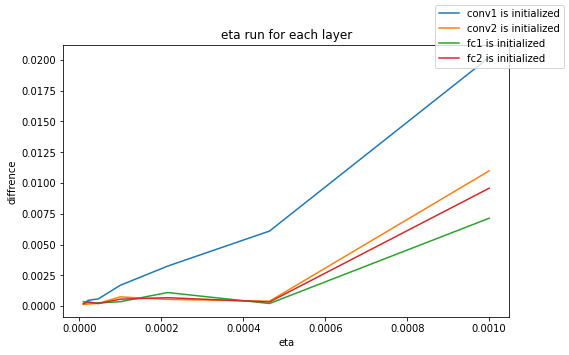

In [ ]:
#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs[3:10],diff_v_conv1[3:10],label="conv1 is initialized")
plt.plot(lrs[3:10],diff_v_conv2[3:10], label="conv2 is initialized")
plt.plot(lrs[3:10],diff_v_fc1[3:10], label= "fc1 is initialized")
plt.plot(lrs[3:10],diff_v_fc2[3:10], label= "fc2 is initialized")

plt.ylabel('diffrence')
plt.xlabel('eta')
plt.title("eta run for each layer")
fig.legend()
